<a href="https://colab.research.google.com/github/dlskawns/RecSys_and_Retrieval_Study/blob/main/%088_14_Youtube_Rec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YouTube Recommendation
가장 크고 정교한 Real World 추천  
* 딥러닝을 적용해 서비스 성능이 급진적으로 증가
* 2단계 추천
  * Deep Candidate Generation Model -> Query
  * Ranking Model


## Key points

* 매우 큰 유저, 아이템 데이터를 가지기에 이를 효율적으로 계산 및 서빙할 수 있어야 함
* Freshness를 살려 업데이트 되는 컨텐츠 하나하나 바로 추천에 적용할 수 있어야 함
  * 잘 학습된 컨텐츠와 새로 업로드 된 컨텐츠의 조합이 잘 돼야함 (Exploration / Exploitation)
* Sparsity가 높고, 다양한 요인들이 있어 유저 행동 예측이 어려움
* implicit한 저품질 메타데이터를 잘 활용해야함


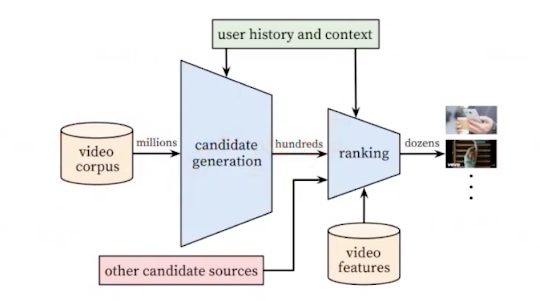

위 그림과 같이, 처음에는 millions의 개수가 있지만, 후보를 뽑은 뒤, 랭킹을 적용하는 방식

* 유저 히스토리와 컨텍스트를 바탕으로 후보 및 랭킹 추출
* 이전 히스토리의 내역에서 컨탠츠들의 features를 파악해 추천에 활용
* Candidate Generation의 목표: Hige recall -> 최대한 사용자가 구매할만한 것들을 끌어모은다.
* Ranking 목표: 유저, 비디오 feature를 좀 더 rich하게 사용해 스코어를 구하고 최종 추천리스트를 제공
  * 비디오 시청기간 등의 정보들



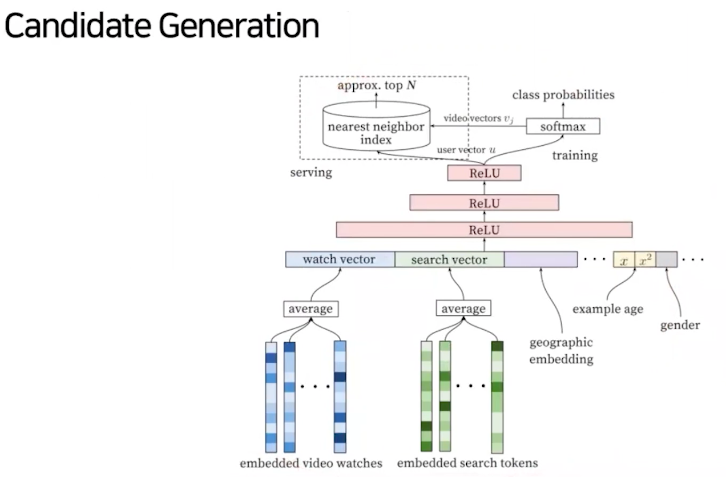

## Candidate Generation 원리
후보군을 추리는 첫번째 단계로 association rule mining을 이용
* Video Classification으로 볼 수 있음 (softmax)
* 사용자 features(watch vector, search vector, etc)를 넣었을 때 어떤 video를 갖는지


### Extreme Multiclass Classification

* class가 수백만개이기 때문에 학습이 매우 어려움
* 사용자 $U$가 특정시간($t$)에 컨텍스트 $C$에서 수백만개의 비디오 ($i$)를 볼 확률을 구하기
  * $P(w_t = i|U,C) = \frac {e^{v_iu}}{\sum_{i \in V}e^{v_ju}}$
  * = softmax의 개별 probability
  * $V$: 비디오 전체
* 유저와 컨텍스트 임베딩을 학습하고 multiclass 분류를 위해 softmax
* Implicit Feedback 데이터를 사용하고, Negative Sampling을 활용
  * 데이터셋이 어떤 유저와 컨텍스트가 어떤 비디오를 봤다 정도의 데이터셋임
  * 좋아요가 있지만 매우 sparse해서 사용치 않음

### Features

유저와 컨텍스트 feature를 활용
* 사용자가 과거 봤던 비디오 / 사용자가 과거에 검색헀던 토큰을 각각 임베딩
* 사용자가 과거에 봤던 비디오나 검색어에 대한 임베딩들의 average pooling을 통해 element - wise한 풀링 방식을 적용한다.
  * watch vector 및 search vector를 생성 가능
* 이외에 다른 meta data들을 넣어주고 concatenate(categorical, continuous features)
  * age, gender같은 geographic vector
  


### 분류기(Softmax)

$K$개의 $x$의 실수값을 총합이 1인 K개의 값으로 뽑아내어 각 class 별 확률값으로 출력  
* class 개수만큼 $K$를 설정하고 $z_i$를 softmaxdp 통과
* 이때 $z_i = w_i^T \cdot x$
  * $x$: 유저벡터
  * $w_i$: 각각 상품 1~$i$까지의 파라미터

* $\frac {e^{v_iu}}{\sum_{i \in V}e^{v_ju}}$의 $v_i, v_j$는 모두 video의 20차원 임베딩의 학습 파라미터
* 유저 벡터 20차원과 video 벡터 20차원으로 softmax를 취한다.



### 실제 서빙에서의 문제

유저벡터를 구한 뒤에 매번 softmax로 백만개의 item 벡터와 유사도를 구해 가장 높은 probability를 구할 순 없음

이를 방지하기 위해 마지막 ReLU까지만 모델을 수행하고 유저 벡터를 구한 뒤, annoy와 같이 군집을 형성하여 미리 만든 모델에 유저 벡터만 통과시켜 최종적으로 가장 높은 아이템 리스트를 출력해내도록 하는 방법

## Ranking
Candidate Generation 으로 나온 $v_1$~v$_{100}$에 대해서 각각의 CTR을 구해 내림차순으로 정렬하는 것  

Candidgate Generation: $v_1c$ = {$v_1,...v_{100}$}  
Ranking: 
  * $P(y|u_1c_1v_1)$ -> 유저, 컨텍스트, 비디오1에 따른 y값(CTR)
  * $P(y|u_1c_1v_2)$ -> 유저, 컨텍스트, 비디오2에 따른 y값(CTR)
  * 위 과정을 통해 top n개를 뽑는것


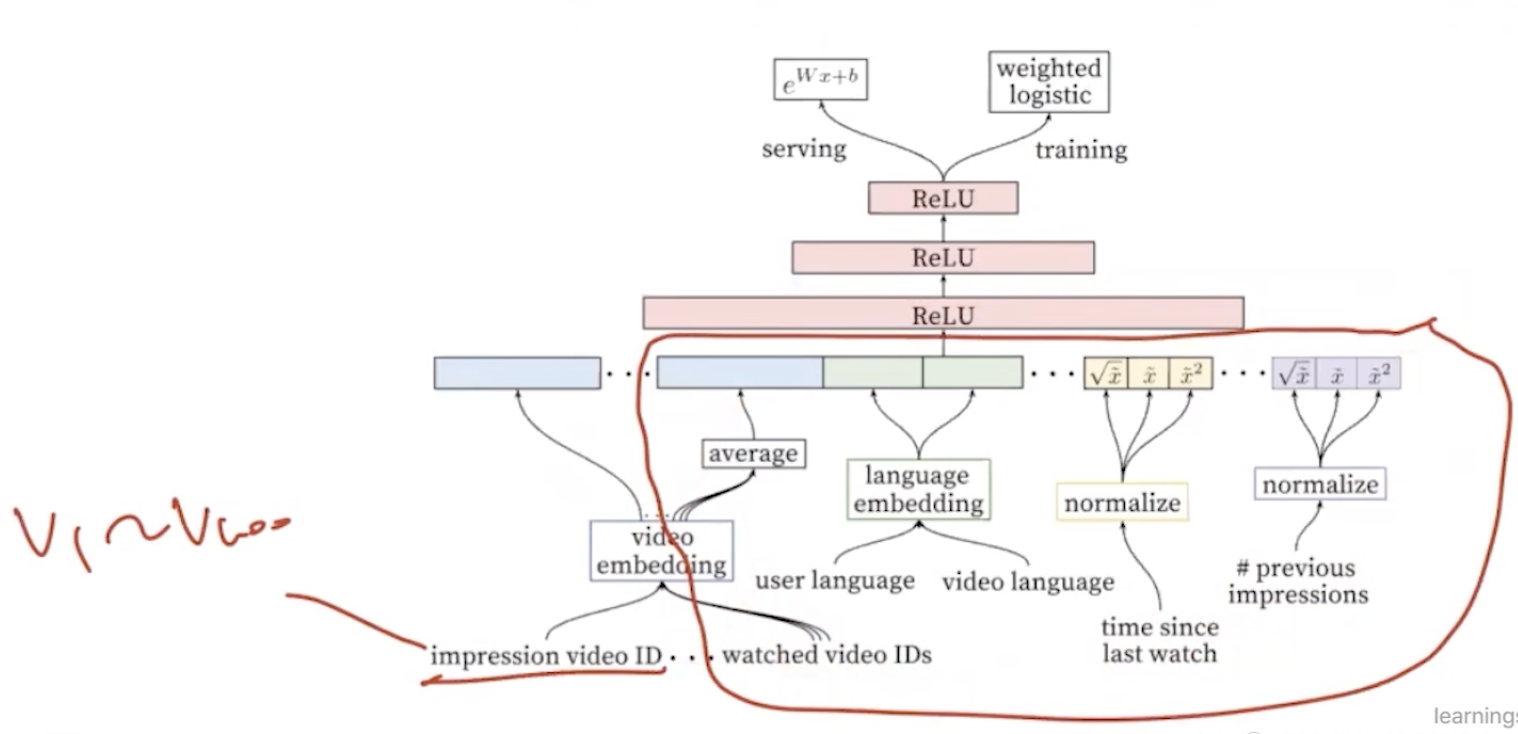

오른쪽 표시된 부분은 유저 $u$, 컨텍스트($c$)로 동일하게 두고, 비디오에 대해 Ranking 수행
* 기존 candidate 때와 달리, 이번엔 비디오가 정해졌기 때문에 비디오에 대한 feature도 추가 가능
  * video language, previous impressions # 등
* Expected watch time
  * CTR이 아닌 기대 예측시간을 구하는 것
  * weighted logistic regression을 통해 sorting 가능
  



## Youtube Recsys 활용
* candidate generation, Ranking 두 개 모델을 활용
* CF보다 더 많은 feature를 사용가능
* categorical - embedding / numerical - normalize 활용
* hidden layer 수는 수많은 feature들 간의 비선형적 관계를 잘 모델링할 수 있음
